In [50]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import warnings
warnings.filterwarnings('ignore')

In [51]:
# globals
seed = 42

In [52]:
df = pd.read_csv('../data/our_features_cleaned_revised.csv')
display(df.head())
print(f"Shape of dataset: {df.shape}\n")
print(f"Unique target values: {df['X5GPAALL'].unique()}")

,STU_ID,X1TXMTSCOR,X1PAREDU,X1SES,X1MTHINT,X1SCIINT,X2TXMTSCOR,X2PAREDU,X2BEHAVEIN,X2MTHINT_R,...,A1MSPRGMS,A1HRTEACHERS,A1HRSTUDENT,A1TCHRABSENT,A1PRNTINV,A1UNPREP,A1HEALTH,A1RESOURCES,C1PLANPARENT,C1SIGNOFF
0,10001,59.3710,5,1.5644,0.12,-0.23,68.6447,6,-2.17,-0.21,...,1,5,3,1,2,1,1,2,-7,-7
1,10002,47.6821,3,-0.3699,-9.00,-9.00,54.0863,4,0.61,-0.60,...,0,7,9,2,3,3,3,2,-9,-9
2,10003,64.2431,7,1.2741,0.86,0.93,55.6336,7,0.52,-1.39,...,1,15,5,2,2,2,2,2,1,0
3,10006,58.1268,3,1.0639,2.08,-7.00,53.9958,5,0.89,-7.00,...,0,3,6,-9,4,4,2,2,1,1
4,10007,49.4960,2,-0.4300,2.08,0.16,47.6403,2,0.39,-0.47,...,1,8,6,1,1,1,1,1,1,1


Shape of dataset: (12588, 54)

Unique target values: [3 1 0 2]


In [53]:
df = df.drop(columns=["STU_ID"])
df.X5GPAALL.value_counts()

X5GPAALL
1    4107
2    3164
3    2899
0    2418
Name: count, dtype: int64

In [54]:
df = df.replace([-1,-2,-3,-4,-5,-6,-7,-8,-9],np.nan)

In [55]:
X = df.drop(columns=["X5GPAALL", "X3TGPAACAD"])
y = df.X5GPAALL

In [56]:
y

0        3
1        1
2        1
3        1
4        0
        ..
12583    2
12584    3
12585    0
12586    0
12587    3
Name: X5GPAALL, Length: 12588, dtype: int64

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = seed, stratify=y
)

In [58]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

# --- STEP 1: DEFINE COLUMNS AND INSTANTIATE TOOLS ---
bool_cols = ["A1MSMENTOR", "A1MSSPEAKER", "A1MSFLDTRIP", "A1MSPRGMS"]
cat_cols = [
    "X2PAREDU", "X1PAREDU", "X3TGPAHIMTH", "X3TGPAHISCI", "X3TGPASTEM",
    "A1TCHRABSENT", "A1PRNTINV", "A1UNPREP", "A1HEALTH", "A1RESOURCES", "A1SCHCONTROL",
    "S2LATESCH", "S2ABSENT", "S2WOHWDN", "S2WOPAPER", "S2WOBOOKS", "S2SKIPCLASS", 
    "S2INSCHSUSP", "S2OUTSCHSUSP", "S2DISCIPLINE", "S2EXPELLED", "S2ARRESTED", "S2JUVHOME"
]
# Define num_cols based on exclusion
num_cols = [c for c in X_train.columns if c not in bool_cols and c not in cat_cols]

# Define Imputers, Scaler, and Encoder
num_imputer = SimpleImputer(strategy="mean")
bool_imputer = SimpleImputer(strategy="most_frequent")
cat_imputer = SimpleImputer(strategy="most_frequent")
scaler = StandardScaler()
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# --- STEP 2: PREPROCESS TRAINING DATA ---
# A. Split by type
X_train_num = X_train[num_cols]
X_train_bool = X_train[bool_cols]
X_train_cat = X_train[cat_cols]

# B. Impute
X_train_num_imp = pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=num_cols, index=X_train.index)
X_train_bool_imp = pd.DataFrame(bool_imputer.fit_transform(X_train_bool), columns=bool_cols, index=X_train.index)
X_train_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_cat), columns=cat_cols, index=X_train.index)

# C. Scale (Numeric Only) - ADDED HERE
X_train_scale = pd.DataFrame(scaler.fit_transform(X_train_num_imp), columns=num_cols, index=X_train.index)

# D. Encode (Categorical Only)
X_train_cat_encoded = encoder.fit_transform(X_train_cat_imp)
X_train_cat_encoded_df = pd.DataFrame(
    X_train_cat_encoded, 
    columns=encoder.get_feature_names_out(cat_cols), 
    index=X_train.index
)

# E. Combine (Using Scaled Num, Imputed Bool, and Encoded Cat)
X_train_final = pd.concat([X_train_scale, X_train_bool_imp, X_train_cat_encoded_df], axis=1)

# --- STEP 3: APPLY SMOTE (TRAINING ONLY) ---
print(f"Original Class Distribution: {Counter(y_train)}")

# Strategy: Upsample Class 2 to match the majority class
majority_count = y_train.value_counts().max()
strategy = {2: majority_count} 

smote = SMOTE(sampling_strategy=strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train)

# Convert back to DataFrame
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train_final.columns)

print(f"Resampled Class Distribution: {Counter(y_train_resampled)}")

# --- STEP 4: PREPROCESS TEST DATA (TRANSFORM ONLY) ---
# A. Split
X_test_num = X_test[num_cols]
X_test_bool = X_test[bool_cols]
X_test_cat = X_test[cat_cols]

# B. Impute
X_test_num_imp = pd.DataFrame(num_imputer.transform(X_test_num), columns=num_cols, index=X_test.index)
X_test_bool_imp = pd.DataFrame(bool_imputer.transform(X_test_bool), columns=bool_cols, index=X_test.index)
X_test_cat_imp = pd.DataFrame(cat_imputer.transform(X_test_cat), columns=cat_cols, index=X_test.index)

# C. Scale
X_test_scale = pd.DataFrame(scaler.transform(X_test_num_imp), columns=num_cols, index=X_test.index)

# D. Encode
X_test_cat_encoded = encoder.transform(X_test_cat_imp)
X_test_cat_encoded_df = pd.DataFrame(
    X_test_cat_encoded, 
    columns=encoder.get_feature_names_out(cat_cols), 
    index=X_test.index
)

# E. Combine
X_test_final = pd.concat([X_test_scale, X_test_bool_imp, X_test_cat_encoded_df], axis=1)

Original Class Distribution: Counter({1: 3080, 2: 2373, 3: 2174, 0: 1814})
Resampled Class Distribution: Counter({1: 3080, 2: 3080, 3: 2174, 0: 1814})


In [59]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1, include_bias=False)

X_train_poly = poly.fit_transform(X_train_resampled)

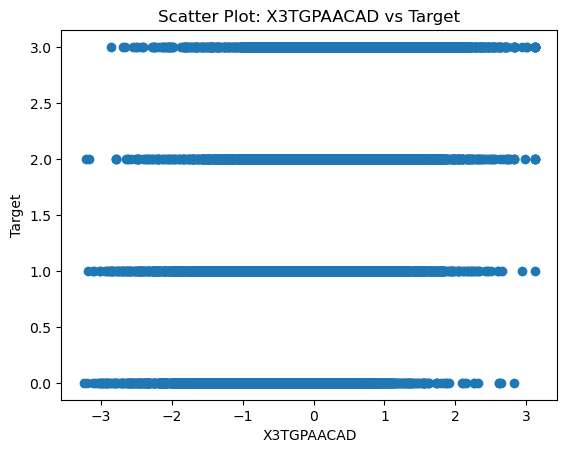

In [60]:
plt.scatter(X_train_final.iloc[:, 0], y_train)
plt.xlabel("X3TGPAACAD")
plt.ylabel("Target")
plt.title("Scatter Plot: X3TGPAACAD vs Target")
plt.show()

In [61]:
X_train_final

,X1TXMTSCOR,X1SES,X1MTHINT,X1SCIINT,X2TXMTSCOR,X2BEHAVEIN,X2MTHINT_R,X2SCIINT,X4X2SES,S1GOODGRADES,...,S2INSCHSUSP_2.0,S2INSCHSUSP_3.0,S2INSCHSUSP_4.0,S2INSCHSUSP_5.0,S2OUTSCHSUSP_2.0,S2OUTSCHSUSP_3.0,S2DISCIPLINE_2.0,S2EXPELLED_2.0,S2ARRESTED_2.0,S2JUVHOME_2.0
217,-0.801822,-1.817668,8.590046e-01,-8.022230e-01,-1.231048,0.471929,1.847570,-1.040061,-1.620208,-0.703967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5369,1.225619,-0.324928,1.478041e+00,1.853604e+00,0.812977,0.879719,2.280817,1.570421,0.419051,-0.703967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5870,-1.485137,-1.256145,-3.446765e-01,-2.752963e+00,-0.670612,0.688567,0.658919,-0.131567,-0.944860,-0.703967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4870,0.289007,-0.037181,-3.217492e-01,-9.314889e-01,-0.003642,0.217060,-1.507315,0.707927,0.713000,1.235782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4417,-0.440493,-1.036774,3.181796e-17,4.434304e-01,-0.560510,0.064139,-0.629712,-1.396559,-1.419157,1.235782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,1.704288,0.478803,4.921684e-01,4.388120e-02,1.496490,0.586620,-0.796346,0.661927,1.667860,1.235782,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7418,0.692817,-0.151232,8.590046e-01,-4.966854e-01,-0.378831,1.058127,-0.796346,-1.454059,-0.394419,-0.703967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,-1.090204,-0.766087,3.181796e-17,-3.261682e-17,-0.425604,-1.108258,-2.229392,-2.661551,-0.877842,-0.703967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7049,2.362046,1.835730,1.397795e+00,4.904362e-01,2.383356,1.045384,0.000000,0.000000,2.102791,-0.703967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model = LogisticRegression(max_iter=1000, random_state=seed, class_weight='balanced')
mlr_model.fit(X_train_resampled, y_train_resampled)

mlr_y_hat1 = mlr_model.predict(X_test_final)

mlr_precision_1 = precision_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("Precision:", mlr_precision_1)
mlr_recall_1 = recall_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("Recall:", mlr_recall_1)
mlr_f1_1 = f1_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_1)
mlr_accuracy_1 = accuracy_score(y_test, mlr_y_hat1)
print("Accuracy:", mlr_accuracy_1)
print(classification_report(y_test, mlr_y_hat1, zero_division=0))

Precision: 0.42529742881812427
Recall: 0.4464997538879999
F1 Score: 0.42918296043453247
Accuracy: 0.4258023514458214
              precision    recall  f1-score   support

           0       0.42      0.60      0.49       604
           1       0.44      0.32      0.37      1027
           2       0.35      0.34      0.34       791
           3       0.49      0.54      0.51       725

    accuracy                           0.43      3147
   macro avg       0.43      0.45      0.43      3147
weighted avg       0.43      0.43      0.42      3147



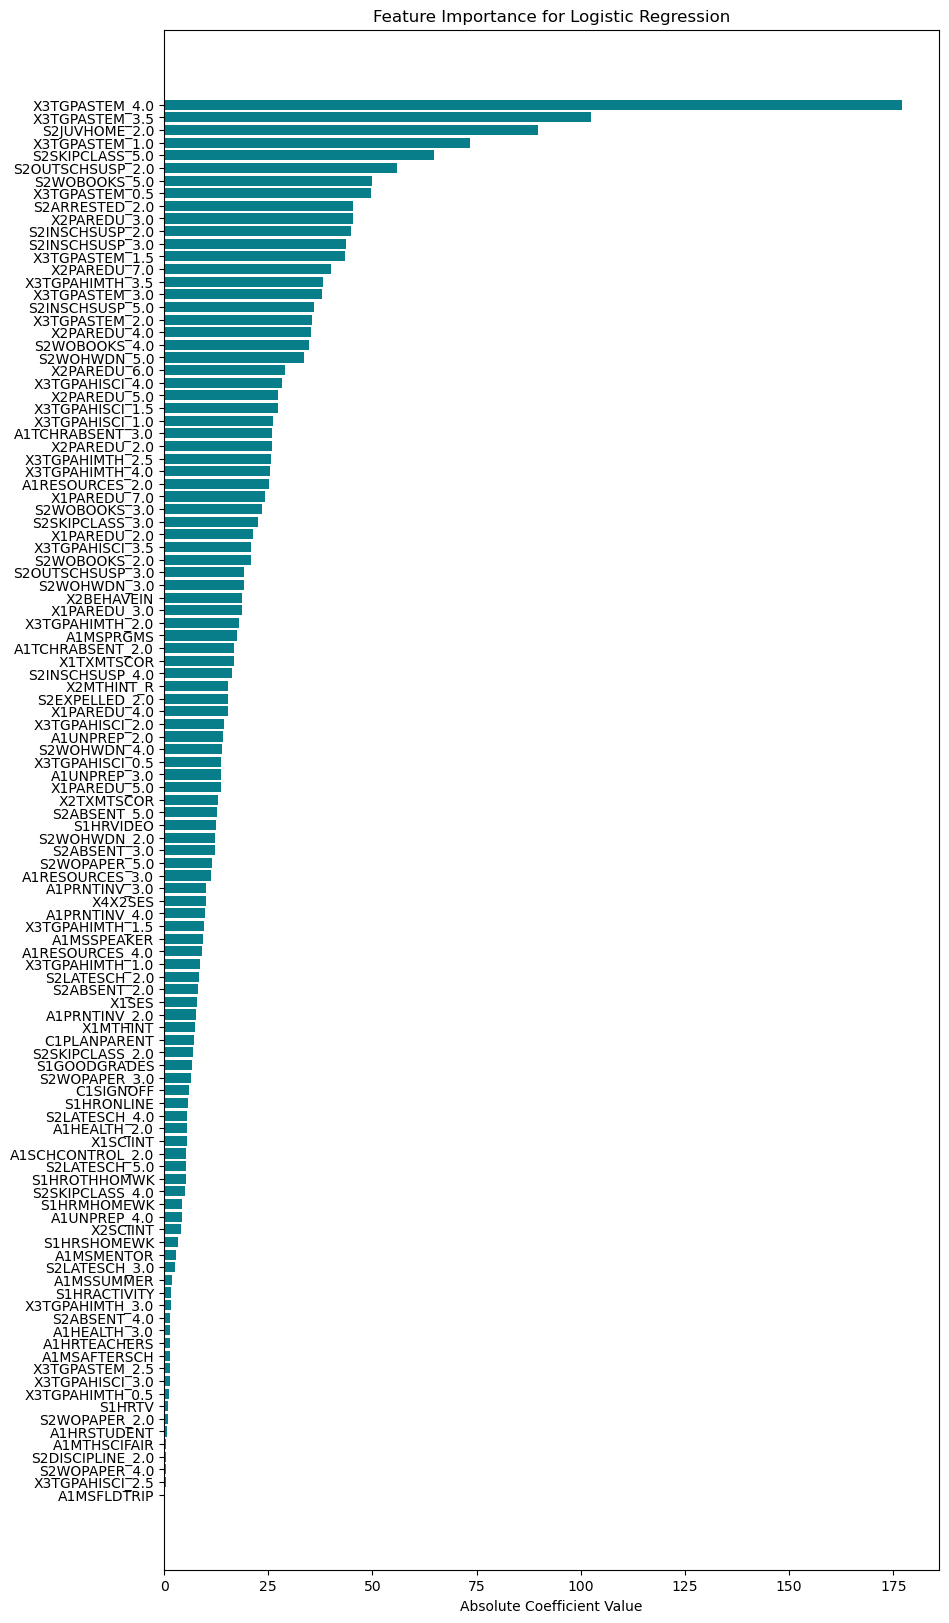

In [63]:
importances = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Importance': np.abs(mlr_model.coef_[0])
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 20))
plt.barh(importances['Feature'], importances['Importance']*100, color='#087E8B')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance for Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf_model_lda = RandomForestClassifier(random_state=seed)

param_grid = {
     'criterion': ['gini', 'entropy'],
     'n_estimators': np.arange(3, 50).tolist()

}

grid_search = GridSearchCV(estimator=rf_model_lda,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro')

grid_search.fit(X_train_resampled, y_train_resampled)

best_critertion = grid_search.best_params_['criterion']
best_max_depth = grid_search.best_params_['n_estimators']

print("Best Critertion: ", best_critertion)
print("Best Max Depth: ", best_max_depth)

rf_model_lda = RandomForestClassifier(criterion=best_critertion, max_depth=best_max_depth, random_state=seed).fit(X_train_resampled, y_train_resampled)

rf_y_hat = rf_model_lda.predict(X_test_final)

rf_precision = precision_score(y_test, rf_y_hat, average="macro", zero_division=0)
print("Precision:", rf_precision)
rf_recall = recall_score(y_test, rf_y_hat, average="macro", zero_division=0)
print("Recall:", rf_recall)
rf_f1 = f1_score(y_test, rf_y_hat, average="macro", zero_division=0)
print("F1 Score:", rf_f1)
rf_accuracy = accuracy_score(y_test, rf_y_hat)
print("Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_y_hat, zero_division=0))

Best Critertion:  entropy
Best Max Depth:  45
Precision: 0.4521478984702274
Recall: 0.42372530506925954
F1 Score: 0.4302642362570982
Accuracy: 0.43914839529710836
              precision    recall  f1-score   support

           0       0.46      0.35      0.40       604
           1       0.41      0.58      0.48      1027
           2       0.36      0.30      0.32       791
           3       0.58      0.46      0.51       725

    accuracy                           0.44      3147
   macro avg       0.45      0.42      0.43      3147
weighted avg       0.45      0.44      0.43      3147



In [77]:
rf_model_lda = RandomForestClassifier(criterion=best_critertion, max_depth=best_max_depth, random_state=seed).fit(X_train_poly, y_train_resampled)

rf_y_hat = rf_model_lda.predict(X_test_final)

rf_precision = precision_score(y_test, rf_y_hat, average="macro", zero_division=0)
print("Precision:", rf_precision)
rf_recall = recall_score(y_test, rf_y_hat, average="macro", zero_division=0)
print("Recall:", rf_recall)
rf_f1 = f1_score(y_test, rf_y_hat, average="macro", zero_division=0)
print("F1 Score:", rf_f1)
rf_accuracy = accuracy_score(y_test, rf_y_hat)
print("Accuracy:", rf_accuracy)
print(classification_report(y_test, rf_y_hat, zero_division=0))

Precision: 0.4521478984702274
Recall: 0.42372530506925954
F1 Score: 0.4302642362570982
Accuracy: 0.43914839529710836
              precision    recall  f1-score   support

           0       0.46      0.35      0.40       604
           1       0.41      0.58      0.48      1027
           2       0.36      0.30      0.32       791
           3       0.58      0.46      0.51       725

    accuracy                           0.44      3147
   macro avg       0.45      0.42      0.43      3147
weighted avg       0.45      0.44      0.43      3147



In [65]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

model = SVC(kernel='rbf').fit(X_train_resampled, y_train_resampled)

svm_y_hat3 = model.predict(X_test_final)

mlr_precision_3 = precision_score(y_test, svm_y_hat3, average="macro", zero_division=0)
print("Precision:", mlr_precision_3)
mlr_recall_3 = recall_score(y_test, svm_y_hat3, average="macro", zero_division=0)
print("Recall:", mlr_recall_3)
mlr_f1_3 = f1_score(y_test, svm_y_hat3, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_3)
mlr_accuracy_3 = accuracy_score(y_test, svm_y_hat3)
print("Accuracy:", mlr_accuracy_3)
print(classification_report(y_test, svm_y_hat3, zero_division=0))

Precision: 0.45616746749130344
Recall: 0.41387272868581443
F1 Score: 0.4231105785590714
Accuracy: 0.4299332697807436
              precision    recall  f1-score   support

           0       0.45      0.32      0.37       604
           1       0.42      0.54      0.47      1027
           2       0.35      0.42      0.38       791
           3       0.60      0.38      0.47       725

    accuracy                           0.43      3147
   macro avg       0.46      0.41      0.42      3147
weighted avg       0.45      0.43      0.43      3147



In [66]:
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

model = SVC(kernel='rbf').fit(X_train_poly, y_train_resampled)

svm_y_hat3 = model.predict(X_test_final)

mlr_precision_3 = precision_score(y_test, svm_y_hat3, average="macro", zero_division=0)
print("Precision:", mlr_precision_3)
mlr_recall_3 = recall_score(y_test, svm_y_hat3, average="macro", zero_division=0)
print("Recall:", mlr_recall_3)
mlr_f1_3 = f1_score(y_test, svm_y_hat3, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_3)
mlr_accuracy_3 = accuracy_score(y_test, svm_y_hat3)
print("Accuracy:", mlr_accuracy_3)
print(classification_report(y_test, svm_y_hat3, zero_division=0))

Precision: 0.45616746749130344
Recall: 0.41387272868581443
F1 Score: 0.4231105785590714
Accuracy: 0.4299332697807436
              precision    recall  f1-score   support

           0       0.45      0.32      0.37       604
           1       0.42      0.54      0.47      1027
           2       0.35      0.42      0.38       791
           3       0.60      0.38      0.47       725

    accuracy                           0.43      3147
   macro avg       0.46      0.41      0.42      3147
weighted avg       0.45      0.43      0.43      3147



In [67]:
import statsmodels.api as sm

def backward_elimination(X, y, sl=0.05, dropped=None):
    if dropped is None:
        dropped = []

    # Fit OLS with an intercept
    X_with_const = sm.add_constant(X)
    X_with_const = X_with_const.astype("float64")
    model = sm.MNLogit(y, X_with_const).fit(disp=False)

    # Extract p-values of x values
    pvalues = model.pvalues.iloc[1:]

    # Find the maximum p-value and corresponding feature
    pvalues = model.pvalues.iloc[1:]  # exclude intercept
    max_pvals = pvalues.max(axis=1)   # max p-value per feature

    # Find the feature with the highest p-value
    max_pval = max_pvals.max()
    if max_pval > sl:
        feature_to_drop = max_pvals.idxmax()
        dropped.append(feature_to_drop)

        # Recurse without that feature
        return backward_elimination(
            X.drop(columns=[feature_to_drop]),
            y,
            sl,
            dropped
        )
    else:
        # Stop recursion; all p-values are below threshold
        retained = list(X.columns)
        return retained, dropped, model

In [68]:
retained_1, dropped_1, final_ols_1 = backward_elimination(X_train_resampled, y_train_resampled, sl=0.10)

print("Retained features:")
print(retained_1)

print("\nDropped features:")
print(dropped_1)

Retained features:
['X1TXMTSCOR', 'X1SES', 'X1MTHINT', 'X1SCIINT', 'X2TXMTSCOR', 'X2BEHAVEIN', 'X2MTHINT_R', 'X2SCIINT', 'X4X2SES', 'S1GOODGRADES', 'S1HRMHOMEWK', 'S1HRSHOMEWK', 'S1HROTHHOMWK', 'S1HRACTIVITY', 'S1HRTV', 'S1HRVIDEO', 'S1HRONLINE', 'A1MTHSCIFAIR', 'A1MSSUMMER', 'A1MSAFTERSCH', 'A1HRTEACHERS', 'A1HRSTUDENT', 'C1PLANPARENT', 'C1SIGNOFF', 'A1MSMENTOR', 'A1MSSPEAKER', 'A1MSFLDTRIP', 'A1MSPRGMS', 'X2PAREDU_2.0', 'X2PAREDU_3.0', 'X2PAREDU_4.0', 'X2PAREDU_5.0', 'X2PAREDU_6.0', 'X2PAREDU_7.0', 'X1PAREDU_2.0', 'X1PAREDU_3.0', 'X1PAREDU_4.0', 'X1PAREDU_5.0', 'X1PAREDU_7.0', 'X3TGPAHIMTH_0.5', 'X3TGPAHIMTH_1.0', 'X3TGPAHIMTH_1.5', 'X3TGPAHIMTH_2.0', 'X3TGPAHIMTH_2.5', 'X3TGPAHIMTH_3.0', 'X3TGPAHIMTH_3.5', 'X3TGPAHIMTH_4.0', 'X3TGPAHISCI_0.5', 'X3TGPAHISCI_1.0', 'X3TGPAHISCI_1.5', 'X3TGPAHISCI_2.0', 'X3TGPAHISCI_2.5', 'X3TGPAHISCI_3.0', 'X3TGPAHISCI_3.5', 'X3TGPAHISCI_4.0', 'X3TGPASTEM_0.5', 'X3TGPASTEM_1.0', 'X3TGPASTEM_1.5', 'X3TGPASTEM_2.0', 'X3TGPASTEM_2.5', 'X3TGPASTEM_3.0', 'X

In [69]:
retained_5, dropped_5, final_ols_5 = backward_elimination(X_train_resampled, y_train_resampled, sl=0.05)

print("Retained features:")
print(retained_5)

print("\nDropped features:")
print(dropped_5)

Retained features:
['X1TXMTSCOR', 'X1SES', 'X1MTHINT', 'X1SCIINT', 'X2TXMTSCOR', 'X2BEHAVEIN', 'X2MTHINT_R', 'X2SCIINT', 'X4X2SES', 'S1GOODGRADES', 'S1HRMHOMEWK', 'S1HRSHOMEWK', 'S1HROTHHOMWK', 'S1HRACTIVITY', 'S1HRTV', 'S1HRVIDEO', 'S1HRONLINE', 'A1MTHSCIFAIR', 'A1MSSUMMER', 'A1MSAFTERSCH', 'A1HRTEACHERS', 'A1HRSTUDENT', 'C1PLANPARENT', 'C1SIGNOFF', 'A1MSMENTOR', 'A1MSSPEAKER', 'A1MSFLDTRIP', 'A1MSPRGMS', 'X2PAREDU_2.0', 'X2PAREDU_3.0', 'X2PAREDU_4.0', 'X2PAREDU_5.0', 'X2PAREDU_6.0', 'X2PAREDU_7.0', 'X1PAREDU_2.0', 'X1PAREDU_3.0', 'X1PAREDU_4.0', 'X1PAREDU_5.0', 'X1PAREDU_7.0', 'X3TGPAHIMTH_0.5', 'X3TGPAHIMTH_1.0', 'X3TGPAHIMTH_1.5', 'X3TGPAHIMTH_2.0', 'X3TGPAHIMTH_2.5', 'X3TGPAHIMTH_3.0', 'X3TGPAHIMTH_3.5', 'X3TGPAHIMTH_4.0', 'X3TGPAHISCI_0.5', 'X3TGPAHISCI_1.0', 'X3TGPAHISCI_1.5', 'X3TGPAHISCI_2.0', 'X3TGPAHISCI_2.5', 'X3TGPAHISCI_3.0', 'X3TGPAHISCI_3.5', 'X3TGPAHISCI_4.0', 'X3TGPASTEM_0.5', 'X3TGPASTEM_1.0', 'X3TGPASTEM_1.5', 'X3TGPASTEM_2.0', 'X3TGPASTEM_2.5', 'X3TGPASTEM_3.0', 'X

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

X_train_reduced5 = X_train_resampled[retained_5]
X_test_reduced5 = X_test_final[retained_5]

mlr_model3 = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model3.fit(X_train_reduced5, y_train_resampled)

mlr_y_hat3 = mlr_model3.predict(X_test_reduced5)

mlr_precision_3 = precision_score(y_test, mlr_y_hat3, average="macro", zero_division=0)
print("Precision:", mlr_precision_3)
mlr_recall_3 = recall_score(y_test, mlr_y_hat3, average="macro", zero_division=0)
print("Recall:", mlr_recall_3)
mlr_f1_3 = f1_score(y_test, mlr_y_hat3, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_3)
mlr_accuracy_3 = accuracy_score(y_test, mlr_y_hat3)
print("Accuracy:", mlr_accuracy_3)
print(classification_report(y_test, mlr_y_hat3, zero_division=0))

Precision: 0.47658950663843924
Recall: 0.44150087283702083
F1 Score: 0.4504672403825501
Accuracy: 0.4496345726088338
              precision    recall  f1-score   support

           0       0.50      0.39      0.44       604
           1       0.45      0.50      0.48      1027
           2       0.35      0.47      0.40       791
           3       0.60      0.41      0.49       725

    accuracy                           0.45      3147
   macro avg       0.48      0.44      0.45      3147
weighted avg       0.47      0.45      0.45      3147



In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model.fit(X_train_resampled, y_train_resampled)

mlr_y_hat1 = mlr_model.predict(X_test_final)

mlr_precision_1 = precision_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("Precision:", mlr_precision_1)
mlr_recall_1 = recall_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("Recall:", mlr_recall_1)
mlr_f1_1 = f1_score(y_test, mlr_y_hat1, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_1)
mlr_accuracy_1 = accuracy_score(y_test, mlr_y_hat1)
print("Accuracy:", mlr_accuracy_1)
print(classification_report(y_test, mlr_y_hat1, zero_division=0))

Precision: 0.47658950663843924
Recall: 0.44150087283702083
F1 Score: 0.4504672403825501
Accuracy: 0.4496345726088338
              precision    recall  f1-score   support

           0       0.50      0.39      0.44       604
           1       0.45      0.50      0.48      1027
           2       0.35      0.47      0.40       791
           3       0.60      0.41      0.49       725

    accuracy                           0.45      3147
   macro avg       0.48      0.44      0.45      3147
weighted avg       0.47      0.45      0.45      3147



In [72]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

X_train_lda = lda.fit_transform(X_train_resampled, y_train_resampled)
X_test_lda = lda.transform(X_test_final)

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model_lda = LogisticRegression(max_iter=1000, random_state=seed, class_weight='balanced')
mlr_model_lda.fit(X_train_lda, y_train_resampled)

mlr_y_hat5 = mlr_model_lda.predict(X_test_lda)

mlr_precision_5 = precision_score(y_test, mlr_y_hat5, average="macro", zero_division=0)
print("Precision:", mlr_precision_5)
mlr_recall_5 = recall_score(y_test, mlr_y_hat5, average="macro", zero_division=0)
print("Recall:", mlr_recall_5)
mlr_f1_5 = f1_score(y_test, mlr_y_hat5, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_5)
mlr_accuracy_5 = accuracy_score(y_test, mlr_y_hat5)
print("Accuracy:", mlr_accuracy_5)
print(classification_report(y_test, mlr_y_hat5, zero_division=0))

Precision: 0.44013837648935583
Recall: 0.451141830387904
F1 Score: 0.4417982374930779
Accuracy: 0.43469971401334606
              precision    recall  f1-score   support

           0       0.44      0.58      0.50       604
           1       0.44      0.35      0.39      1027
           2       0.34      0.37      0.36       791
           3       0.54      0.50      0.52       725

    accuracy                           0.43      3147
   macro avg       0.44      0.45      0.44      3147
weighted avg       0.44      0.43      0.43      3147



In [74]:
from sklearn.decomposition import PCA

pca18 = PCA(n_components = 18)
X_train_pca18 = pca18.fit_transform(X_train_resampled)
X_test_pca18 = pca18.transform(X_test_final)

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

mlr_model_pca = LogisticRegression(max_iter=1000, random_state=seed)
mlr_model_pca.fit(X_train_pca18, y_train_resampled)

mlr_y_hat4 = mlr_model_pca.predict(X_test_pca18)

mlr_precision_4 = precision_score(y_test, mlr_y_hat4, average="macro", zero_division=0)
print("Precision:", mlr_precision_4)
mlr_recall_4 = recall_score(y_test, mlr_y_hat4, average="macro", zero_division=0)
print("Recall:", mlr_recall_4)
mlr_f1_4 = f1_score(y_test, mlr_y_hat4, average="macro", zero_division=0)
print("F1 Score:", mlr_f1_4)
mlr_accuracy_4 = accuracy_score(y_test, mlr_y_hat4)
print("Accuracy:", mlr_accuracy_4)
print(classification_report(y_test, mlr_y_hat4, zero_division=0))

Precision: 0.4250143024462567
Recall: 0.374084947224817
F1 Score: 0.3765893034276376
Accuracy: 0.39466158245948524
              precision    recall  f1-score   support

           0       0.45      0.20      0.28       604
           1       0.41      0.50      0.45      1027
           2       0.32      0.48      0.38       791
           3       0.52      0.32      0.40       725

    accuracy                           0.39      3147
   macro avg       0.43      0.37      0.38      3147
weighted avg       0.42      0.39      0.39      3147



In [76]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

ada_model_lda = AdaBoostClassifier(estimator=mlr_model3, n_estimators=1000, random_state=seed).fit(X_train_resampled, y_train_resampled)

ada_y_hat = ada_model_lda.predict(X_test_final)

ada_precision = precision_score(y_test, ada_y_hat, average="macro", zero_division=0)
print("Precision:", ada_precision)
ada_recall = recall_score(y_test, ada_y_hat, average="macro", zero_division=0)
print("Recall:", ada_recall)
ada_f1 = f1_score(y_test, ada_y_hat, average="macro", zero_division=0)
print("F1 Score:", ada_f1)
ada_accuracy = accuracy_score(y_test, ada_y_hat)
print("Accuracy:", ada_accuracy)
print(classification_report(y_test, ada_y_hat, zero_division=0))

Precision: 0.4314317583318566
Recall: 0.4116469278778214
F1 Score: 0.4151358795093058
Accuracy: 0.411503018748014
              precision    recall  f1-score   support

           0       0.45      0.34      0.39       604
           1       0.43      0.37      0.40      1027
           2       0.31      0.46      0.37       791
           3       0.52      0.47      0.50       725

    accuracy                           0.41      3147
   macro avg       0.43      0.41      0.42      3147
weighted avg       0.43      0.41      0.41      3147

